# Notebook Summary


## **Steps**
- Using XGBoost regressor to predict housing price. 
- Combine training and testing data to get complete cardinality for one-hot-encoding through sklearn.
- Feature processing:
	- Remove outlier through manual identification of feature distribution
	- One-hot encoding on categorical features
	- Normalization on numerical features using MinMaxScaling
- Train test split should be performed after the encoding.

## **Learnings**
**What helps on this task:**
- Include all features
- Increase n_estimators and early-stopping criteria
- Remove samples with outlier from LotArea (manually identified)
- log transformation to reduce non-constant variance over predictions

**What didn't help on this task:**
- Imputation does not help (strategy=constant)
- Remove features who present with high coefficient of variance
- Removing outliers identified through some feature distributions
- Adding MinMaxScaler to numerical features

## Load data

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Load the data, and separate the target
iowa_file_path = '../input/train.csv'
home_data_all = pd.read_csv(iowa_file_path, index_col="Id")
home_data = home_data_all[home_data_all["LotArea"]<45000]

y = np.log(home_data.SalePrice)
X = home_data.drop(['SalePrice'], axis='columns')

test_data_path = '../input/test.csv'
X_test = pd.read_csv(test_data_path, index_col='Id')

X['mode']=0
X_test['mode']=1
X_all = pd.concat([X, X_test])

## Explore data

In [2]:
# 1. Is there all null column
col_with_missing = [c for c in X_all.columns if X_all[c].isnull().all()]
print(col_with_missing)

# 2. plot numerical col dist to identify outliers
s = (X.dtypes == 'object')
numerical_cols = list(s[s==False].index)
print(len(numerical_cols))

# for i in range(len(numerical_cols)):
#     plt.figure(figsize=(4, 3))
#     col_name = numerical_cols[i]
#     ax = sns.scatterplot(x=X_val[col_name], y=y_val)
    
# manually try out outlier condition
# LotArea > 45000
# LowQualFinSF > 100
# GrLivArea > 4000
# PoolArea > 500
# MisVal > 2500

[]
37


## Process features

In [3]:
# identify categorical and its cardinality for encoding
s = (X.dtypes == 'object')
categorical_cols = list(s[s==True].index)
for c in categorical_cols:
    print(c, X[c].nunique())

def impute(X_numerical):
    # Perform imputation on numerical cols
    # Remember to copy back column names and index as imputation removed them
    import numpy as np
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy='constant')
    X_numerical_imputed = pd.DataFrame(imputer.fit_transform(X_numerical))
    X_numerical_imputed.columns = X_numerical.columns
    X_numerical_imputed.index = X_numerical.index
    return X_numerical_imputed

def encoding(X, categorical_cols):
    # Apply one-hot encoder to each column with categorical data
    from sklearn.preprocessing import OneHotEncoder
    OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    X_categorical_oh = pd.DataFrame(OH_encoder.fit_transform(X[categorical_cols]))

    # One-hot encoding removed index; put it back
    X_categorical_oh.index = X.index
    return X_categorical_oh
    
def process_features(X, categorical_cols):
    '''
    - impute numerical features
    - one hot encoding on categorical features
    '''
    
    X_numerical = X.drop(categorical_cols, axis=1)
    # X_numberical_imputed = impute(X_numerical) #block as it does not help

    X_categorical_oh = encoding(X, categorical_cols)
    
    # Add one-hot encoded columns to numerical features
    OH_X_train = pd.concat([X_numerical, X_categorical_oh], axis=1)
    return OH_X_train

EX = process_features(X_all, categorical_cols)
print(EX.shape)

(2906, 311)


In [4]:
# train test split
X_train, X_val, y_train, y_val = train_test_split(EX[EX['mode']==0], y, random_state=11, test_size=0.2)
print(len(X_train), len(X_val))

1157 290


## Train model

In [5]:
# Define XGB

from xgboost import XGBRegressor

gbt_model = XGBRegressor(n_estimators=5000, learning_rate=0.05, n_jobs=8, early_stopping_rounds=1000)
gbt_model.fit(X_train, y_train, 
             eval_set=[(X_val, y_val)], 
             verbose=False)
gbt_pred = gbt_model.predict(X_val)
gbt_mae = mean_absolute_error(np.exp(y_val), np.exp(gbt_pred))
print("Validation MAE for XGB Model: {:,.0f}".format(gbt_mae))


Validation MAE for XGB Model: 15,035


# Error analysis

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Predicted Price (log scale)')

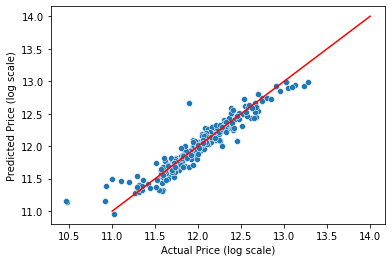

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Predict vs Actual
# obs: high bias over high value regime
ax = sns.scatterplot(x=y_val, y=gbt_pred)
sns.lineplot([11,14], [11,14], color='r')
# ax.set(xscale="log", yscale="log")
ax.set_xlabel("Actual Price (log scale)")
ax.set_ylabel("Predicted Price (log scale)")

Text(0, 0.5, 'Residual')

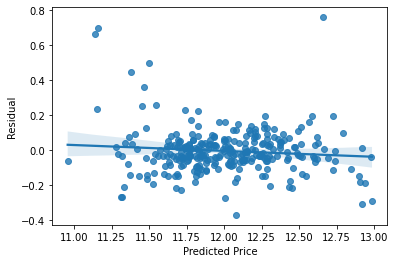

In [7]:
# residual plot
# obs: nonconst-variance, variance is increasing in high value regime
res = gbt_pred - y_val
ax2 = sns.regplot(x=gbt_pred, y=res)
ax2.set_xlabel("Predicted Price")
ax2.set_ylabel("Residual")

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='SalePrice'>

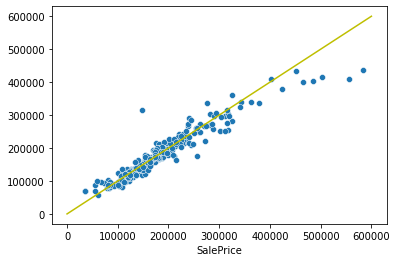

In [8]:
# detecting outlier price
# sns.kdeplot(x=y_train)
# sns.kdeplot(x=y_val)
# y_summary = y_train.describe()
# upper_bound = y_summary['mean'] + y_summary['std']
# len(y_train[y_train>upper_bound])

sns.scatterplot(x=np.exp(y_val), y=np.exp(gbt_pred))
sns.lineplot([0, 600000], [0,600000], color='y')

# Generate a submission

Run the code cell below to generate a CSV file with your predictions that you can use to submit to the competition.

In [9]:
# make predictions which we will submit. 
test_preds = np.exp(gbt_model.predict(EX[EX['mode']==1]))
print(test_preds)

EX[EX['mode']==1].reset_index()

[128585.22 160952.4  193740.77 ... 152672.94 112325.28 228978.83]


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,264,265,266,267,268,269,270,271,272,273
0,1461,20,80.0,11622,5,6,1961,1961,0.0,468.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1462,20,81.0,14267,6,6,1958,1958,108.0,923.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1463,60,74.0,13830,5,5,1997,1998,0.0,791.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1464,60,78.0,9978,6,6,1998,1998,20.0,602.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1465,120,43.0,5005,8,5,1992,1992,0.0,263.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,21.0,1936,4,7,1970,1970,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1455,2916,160,21.0,1894,4,5,1970,1970,0.0,252.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1456,2917,20,160.0,20000,5,7,1960,1996,0.0,1224.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1457,2918,85,62.0,10441,5,5,1992,1992,0.0,337.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [10]:
# Run the code to save predictions in the format used for competition scoring

output = pd.DataFrame({'Id': EX[EX['mode']==1].index,
                       'SalePrice': test_preds})
output.to_csv('submission.csv', index=False)

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/intro-to-machine-learning/discussion) to chat with other learners.*